# Most Significant Variables Affecting Heart Disease


## Introduction

Coronary heart disease is a disease in the heart and coronary arteries which is caused by the buildup of fatty materials in the blood vessels that supply oxygen. This can cause a heart attack, chest pain or angina (clotting). Main factors that affect heart disease (based on the cdc) : High blood pressure, high cholesterol and smoking are key risk factors of heart disease. However other factors also increase the risk of heart disease such as diabetes, physical inactivity, overweightness and obesity.

Hence, the question we want to answer is "Which variables from the dataset have the most significant impact on predicting heart disease?".

The dataset used will be the Cleveland Heart Disease dataset taken from the UCI repository collected in the city of Cleveland Ohio donated in 1988. It consists of 303 individual observations under 76 variables. Of the 76 variables, there were 14 main variables, of which 4 were selected to be analyzed for correlation to the likelihood of an individual to experience heart disease.
Preliminary Exploratory Data Analysis

## Methods & Results

In [1]:
library(dplyr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
library(GGally)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales

In [2]:
# Read data into R
heart_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

# Modify column names 
colnames(heart_disease_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num") 

# Modify datatypes
heart_disease_data <- heart_disease_data |>
    mutate(sex = as.factor(sex)) |>
    mutate(cp = as.factor(cp)) |>
    mutate(fbs = as.factor(fbs)) |>
    mutate(restecg = as.factor(restecg)) |>
    mutate(exang = as.factor(exang)) |>
    mutate(slope = as.factor(slope)) |>
    mutate(thal = as.factor(thal)) |>
    mutate(num = as.factor(num)) |>
    mutate(ca = as.factor(ca))

# Change "?" to NA
heart_disease_data[heart_disease_data == "?"] <- NA

head(heart_disease_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Now we have successfully read the data, modified the column names and the datatype of each variable, we can split the dataset into the training and testing sets. (We changed the datatypes of several columns because these columns are either dummy or categorical variables; therefore we need to change them into factors)

In [3]:
set.seed(9999) 
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

We plan to compare 4 variables as our predictors. We removed the columns that are dummy or categorical variables since these variables cannot be used in KNN classification model to predict the class, and we were left with 5 variables. Of these variables, we selected the 4 variables that we felt have the largest impact on heart disease, that is _age_, _trestbps_, _chol_, and _thalach_. 

_trestbps_ stands for resting blood pressure in mm Hg; _chol_ for serum cholesterol in mg/dl; _thalach_ for maximum heart rate

In [4]:
selected_heart_disease_vars <- heart_disease_training |> 
    select(age, trestbps, chol, thalach, num)
head(selected_heart_disease_vars)

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0
37,130,250,187,0
41,130,204,172,0
56,120,236,178,0
56,140,294,153,0
44,120,263,173,0


Then we can check for missing values:

In [5]:
selected_heart_disease_vars |> 
    filter(is.na(age) | is.na(trestbps) | is.na(chol) | is.na(thalach)| is.na(num))

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>


No missing values in the data.

Using the training data only, we can generate a summary table for the variable _num_.

In [6]:
heart_disease_training |> 
    group_by(num) |> 
    summarize(count = n())

num,count
<fct>,<int>
0,122
1,41
2,27
3,27
4,9


Here we can see that _num_ is a categorical variable with 5 levels: value 0 indicates the absense of heart disease, values 1, 2, 3, 4 represent the presence with different levels. Looking at this table, we can have a rough idea of how people with/without heart disease are distributed. More than half of people do not have heart disease (122 people with 0 level num), and the rest, almost half of people do have heart disease(104 people with num = 1, 2, 3, or 4), with the level 1 being most common and level 4 being the least.

We can also compute the mean of each variable we plan to use as a predictor (age, trestbps, chol, thalach):

In [7]:
heart_disease_training |> 
    summarize(mean_age = mean(age),
              mean_trestbps = mean(trestbps),
              mean_chol = mean(chol),
              mean_thalach = mean(thalach))

mean_age,mean_trestbps,mean_chol,mean_thalach
<dbl>,<dbl>,<dbl>,<dbl>
54.50442,130.9646,249.4248,150.2832


We can further draw out the distribution of each predictor.

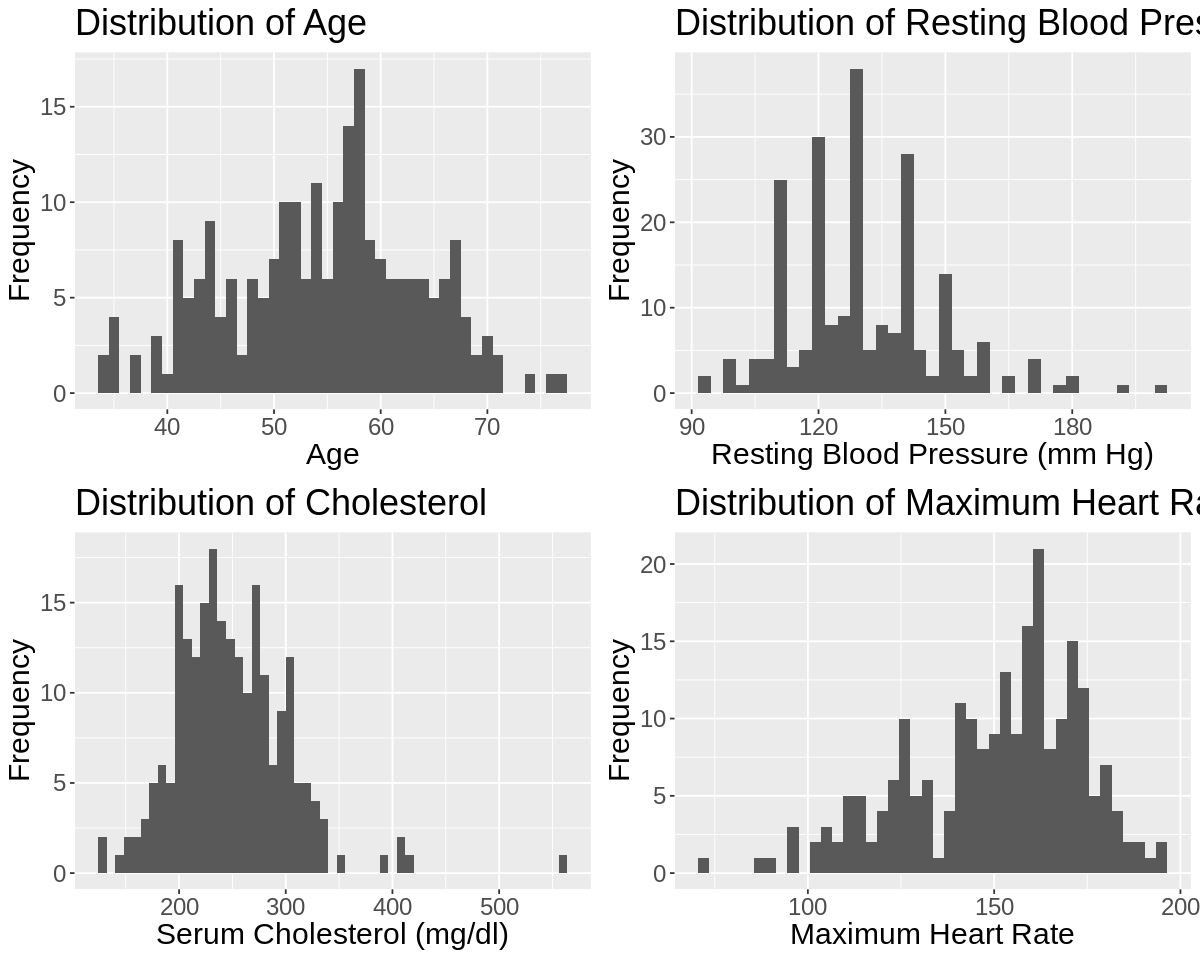

In [8]:
# age distribution
age_dist <- heart_disease_training |> 
    ggplot(aes(x = age)) +
    geom_histogram(binwidth = 1) +
    xlab("Age") +
    ylab("Frequency") +
    ggtitle("Distribution of Age") +
    theme(text = element_text(size = 18))

# trestbps distribution
trestbps_dist <- heart_disease_training |> 
    ggplot(aes(x = trestbps)) +
    geom_histogram(binwidth = 3) +
    xlab("Resting Blood Pressure (mm Hg)") +
    ylab("Frequency") +
    ggtitle("Distribution of Resting Blood Pressure") +
    theme(text = element_text(size = 18))

# chol distribution
chol_dist <- heart_disease_training |> 
    ggplot(aes(x = chol)) +
    geom_histogram(binwidth = 8) +
    xlab("Serum Cholesterol (mg/dl)") +
    ylab("Frequency") +
    ggtitle("Distribution of Cholesterol") +
    theme(text = element_text(size = 18))

# thalach distribution
thalach_dist <- heart_disease_training |> 
    ggplot(aes(x = thalach)) +
    geom_histogram(binwidth = 3) +
    xlab("Maximum Heart Rate") +
    ylab("Frequency") +
    ggtitle("Distribution of Maximum Heart Rate") +
    theme(text = element_text(size = 18))

# plot 4 histograms in one graph
options(repr.plot.height = 8, repr.plot.width = 10)
plot_grid(age_dist, trestbps_dist, chol_dist, thalach_dist, nrow = 2, ncol = 2)

The individuals are mostly between age 40 - 70 and are more centered around 50 - 60.
The majority have resting blood pressure between 120 - 140, cholesterol level between 200 - 300, and maximum heart rate between 150 - 180.

we can explore the correlation between these predictors by plotting scatterplots:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



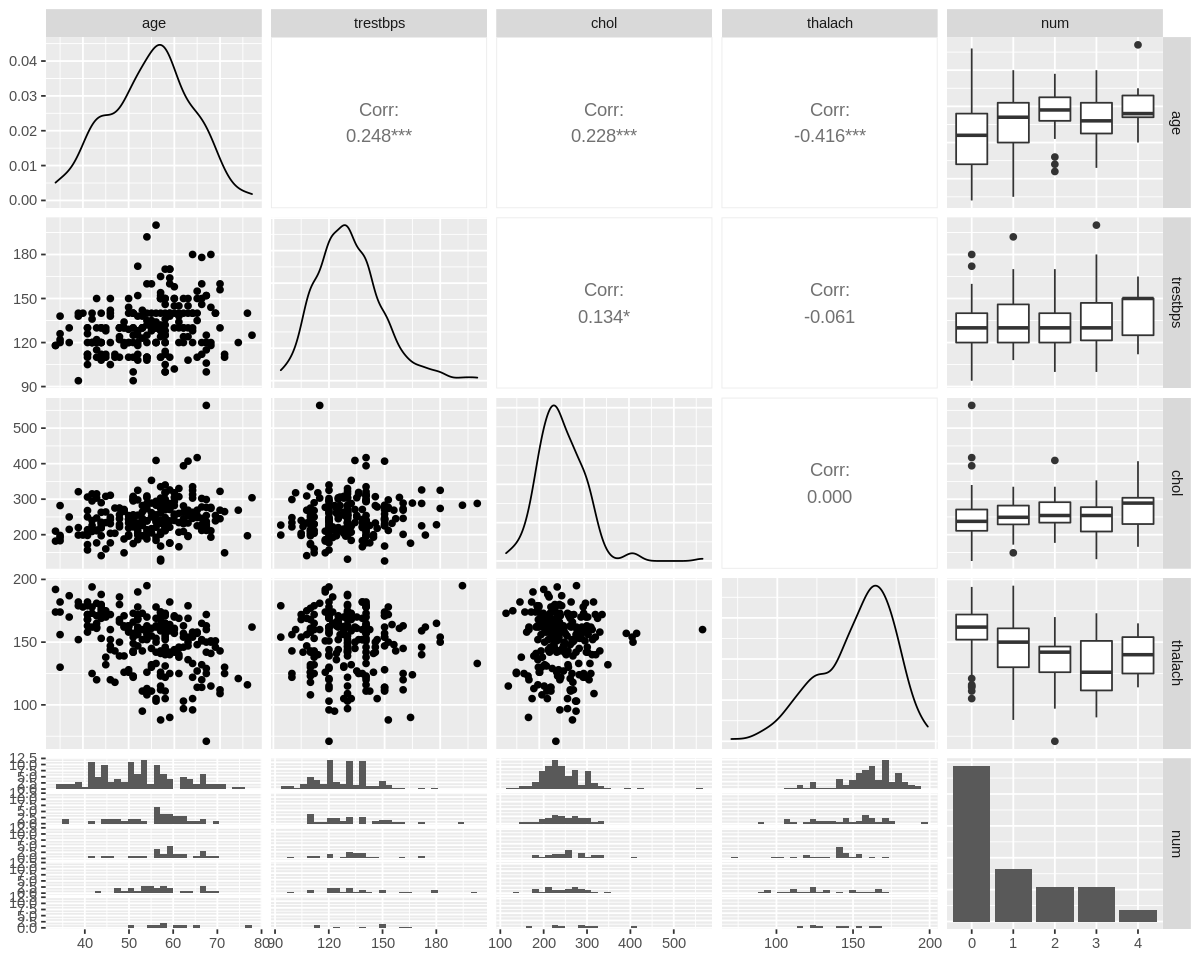

In [9]:
heart_disease_training |> 
    select(age, trestbps, chol, thalach, num) |> 
    ggpairs()

Age and trestbps appear to have a positive relationship, whilst age and thalach appear to have a negative relationship. Further than these 2, no other correlations between variables appear. While the mean of chol does not change much across these categories of num, the means of age and thalach do vary quite a lot. Moreover, only when num = 5 does the mean of trestbps grow significantly.

Now that we have completed the exploratory data analysis, we can create a classification model to answer our research question.

To determine if an individual has heart disease and how accurately we can predict for it using our variables, we first need to create a KNN model of our predictors. 

Below, we will graph the k predictors against the accuracy to determine which k-value is most accurate. It will also tell us the accuracy of our predictor. 


! Fold5: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



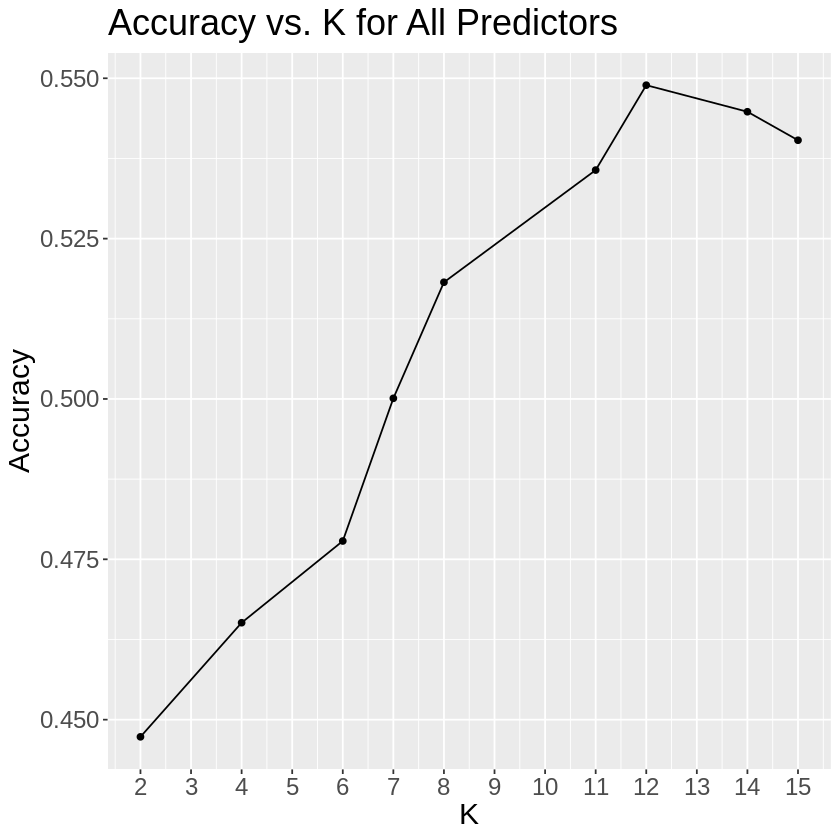

In [10]:
set.seed(9999) 

# create a recipe using all 4 predictors 
all_recipe <- recipe(num ~  age + trestbps + chol + thalach, data = heart_disease_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create a KNN classification model with k unspecified
all_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform cross validation 
all_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)

# fit the model and calculate the accuracy of each K values 
all_accuracy <- workflow() |>
    add_recipe(all_recipe) |>
    add_model(all_knn) |>
    tune_grid(resamples = all_vfold, grid = 10) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# plot the accuracy versus k graph 
options(repr.plot.height = 7, repr.plot.width = 7)
all_acc_plot <- all_accuracy |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "K", y = "Accuracy") +
    ggtitle("Accuracy vs. K for All Predictors") +
    theme(text = element_text(size=18)) +
    scale_x_continuous(breaks = 2:15) 
all_acc_plot 

According to this graph, the highest accuracy is achieved when K = 12; therefore, we can specify neighbors = 12 when generating the KNN model using all 4 predictors. However, it should be noted that even though the accuracy is the most at K = 12, this highest accuracy value only reaches approximatley 0.55, which means the model only predicts 55% of the training data correctly. 

In [11]:
# generate the best KNN classification model, specifying K = 12
all_knn_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
    set_engine("kknn") |>
    set_mode("classification")

# fit the training data using the best model
all_fit <- workflow() |> 
    add_recipe(all_recipe) |> 
    add_model(all_knn_best) |> 
    fit(data = heart_disease_training)

# predict the test dataset using the fit model
all_predict <- predict(all_fit, heart_disease_testing) |> 
    bind_cols(heart_disease_testing) |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy")
all_predict

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4545455


Using the KNN classification model we created above with all 4 predictors, we only predicts 45% of the test dataset correctly, which is not very accurate.

We can take a closer look to the confusion matrix.

In [12]:
predict(all_fit, heart_disease_testing) |> 
    bind_cols(heart_disease_testing) |>
    conf_mat(truth = num, estimate = .pred_class)

          Truth
Prediction  0  1  2  3  4
         0 33 11  5  5  3
         1  4  1  4  1  1
         2  0  1  0  1  0
         3  5  1  0  1  0
         4  0  0  0  0  0

Only 35 values are properly predicted by our model (33 num=0, 1 num=1, 1 num=3), while the remaining 42 values are wrong. 9 numbers should be 0 (no heart disease), however according to our model, they will either be 1 or 3 (with heart disease). More critically, there are 24 values that, in fact, are 1, 2, 3, or 4, but are predicted to be 0, indicating that there are 24 people who actually have heart disease, but are not predicted to have it by our model. As a result of our inaccurate predictions, these patients may not receive the proper therapy, which can have fatal effects.

# Discussion

In our analysis, we decided to examine the 4 most probable variables that would impact heart disease based on the CDC’s examination of the most correlated factors and our personal opinion. We can use this information to determine the probability that an individual has heart disease, based on their qualities of these 4 variables. 

Based on the exploratory analysis of the dataset, the values had a wide range and the histogram distribution of all the variables used can support this. The curves show a normal distribution curve for all the variables except cholesterol which is in the range of 200-300 for most people. Having a wide range of data allows the training data to have more supervised data and allows for better analysis. The correlation plot shows that only two variables have a positive correlation and two with a negative correlation.

The classification models were surprising, given the amount of training data available, the accuracy value we expected was lower than what we calculated in our investigation. The impact of the findings show that the predictors are not very accurate at predicting heart disease. Since the matter is concerning a fatal disease, having the wrong outcome could be very costly as people need proper healthcare and recovery to deal with heart disease. This leads to further questions such as how we could improve the accuracy of the model. Perhaps using more data and more predictor variables would increase the models accuracy.

## Sources

1. Cardiovascular Diseases (CVDs). https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds). Accessed 4 Dec. 2022.
2. CDC. ‘Heart Disease Resources | Cdc.Gov’. Centers for Disease Control and Prevention, 12 July 2022, https://www.cdc.gov/heartdisease/about.htm. Accessed 23 Oct. 2022.
3. Detrano, R. UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. 1988. Irvine, CA: University of California, School of Information and Computer Science. Accessed October 23, 2022.
4. Heart Disease | Background and Policy | Health Topics | Isd Scotland. https://www.isdscotland.org/Health-Topics/Heart-Disease/Background-and-Policy/. Accessed 5 Dec. 2022.
5. ‘Heart Disease - Symptoms and Causes’. Mayo Clinic, https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118. Accessed 5 Dec. 2022.
6. Multiple Cause of Death, 1999-2020 Request. https://wonder.cdc.gov/mcd-icd10.html. Accessed 6 Dec. 2022.
7. Tsao, Connie W., et al. ‘Heart Disease and Stroke Statistics—2022 Update: A Report from the American Heart Association’. Circulation, vol. 145, no. 8, Feb. 2022, pp. e153–639. ahajournals.org (Atypon), https://doi.org/10.1161/CIR.0000000000001052. Accessed 4 Dec. 2022.
8. Virani, Salim S., et al. ‘Heart Disease and Stroke Statistics—2021 Update’. Circulation, vol. 143, no. 8, Feb. 2021, pp. e254–743. ahajournals.org (Atypon), https://doi.org/10.1161/CIR.0000000000000950. Accessed 4 Dec. 2022.